In [42]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
import librosa
import librosa.display
import os
from tensorflow.keras.layers import Input, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

In [51]:
# Load audio data
# noisy_files = ["../data/processed/recording 1.wav", 
#                "../data/processed/recording 2.wav"]
noisy_files = [f for f in os.listdir("../data/processed/") if "recording" in f and f.endswith(".wav")]
noise_files = ["../data/processed/event.wav", "../data/processed/event 2.wav"]
noisy_signals = [librosa.load(os.path.join("../data/processed/", file), sr=44100)[0] for file in noisy_files]
noise_signals = [librosa.load(file, sr=44100)[0] for file in noise_files]

In [52]:
# Preprocess data
def compute_spectrogram(signal):
    return librosa.stft(signal, n_fft=1024, hop_length=512).T
noisy_spectrograms = [compute_spectrogram(signal) for signal in noisy_signals]
noise_spectrograms = [compute_spectrogram(signal) for signal in noise_signals]

In [54]:
# Enhance the model with a U-Net-like architecture for better denoising quality
def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up1 = UpSampling2D((2, 2))(bottleneck)
    concat1 = concatenate([conv2, up1])
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(conv3)
    concat2 = concatenate([conv1, up2])
    conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(concat2)

    outputs = Conv2D(1, (3, 3), activation='linear', padding='same')(conv4)

    return Model(inputs, outputs)

# Build and compile the model
input_shape = (1024, 1024, 1)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='mse')

In [56]:
# Train the model
def pad_spectrograms(spectrograms, target_shape):
	padded_spectrograms = []
	for spectrogram in spectrograms:
		pad_width = [(0, max(0, target_shape[0] - spectrogram.shape[0])), 
					 (0, max(0, target_shape[1] - spectrogram.shape[1]))]
		padded_spectrogram = np.pad(spectrogram, pad_width, mode='constant')
		padded_spectrograms.append(padded_spectrogram[:target_shape[0], :target_shape[1]])
	return np.array(padded_spectrograms)

# Define target shape for spectrograms
target_shape = (1024, 1024)

# Ensure the same number of samples for X_train and y_train
min_samples = min(len(noisy_spectrograms), len(noise_spectrograms))
X_train = pad_spectrograms(noisy_spectrograms[:min_samples], target_shape).reshape(-1, 1024, 1024, 1)
y_train = pad_spectrograms(noise_spectrograms[:min_samples], target_shape).reshape(-1, 1024, 1024, 1)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0315
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0315
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0273
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0273
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0254
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0254
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0248
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0248
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0244
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0244
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0242
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0242
Epoch 7/10
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0239
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0239
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0237
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0237
Epoch 9/

In [57]:
# Apply the model to denoise
denoised_spectrograms = []
for spectrogram in noisy_spectrograms:
	# Ensure the spectrogram has the correct shape
	padded_spectrogram = np.pad(spectrogram, 
								[(0, max(0, target_shape[0] - spectrogram.shape[0])), 
								 (0, max(0, target_shape[1] - spectrogram.shape[1]))], 
								mode='constant')
	reshaped_spectrogram = padded_spectrogram[:target_shape[0], :target_shape[1]].reshape(1, target_shape[0], target_shape[1], 1)
	denoised_spectrogram = model.predict(reshaped_spectrogram)
	denoised_spectrograms.append(denoised_spectrogram[0, :, :, 0])  # Remove batch and channel dimensions

# Convert denoised spectrograms back to time-domain signals
denoised_signals = [librosa.istft(spectrogram.T) for spectrogram in denoised_spectrograms]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


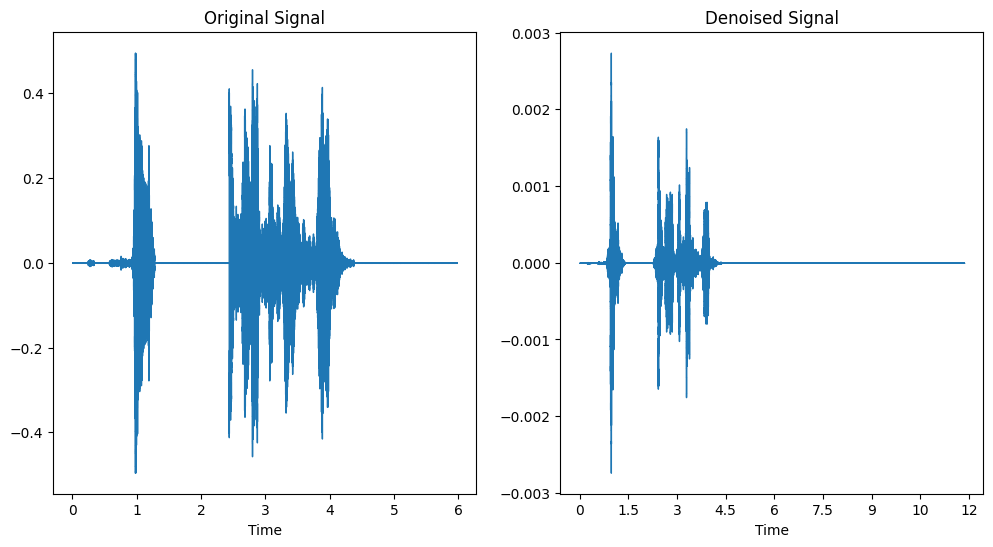

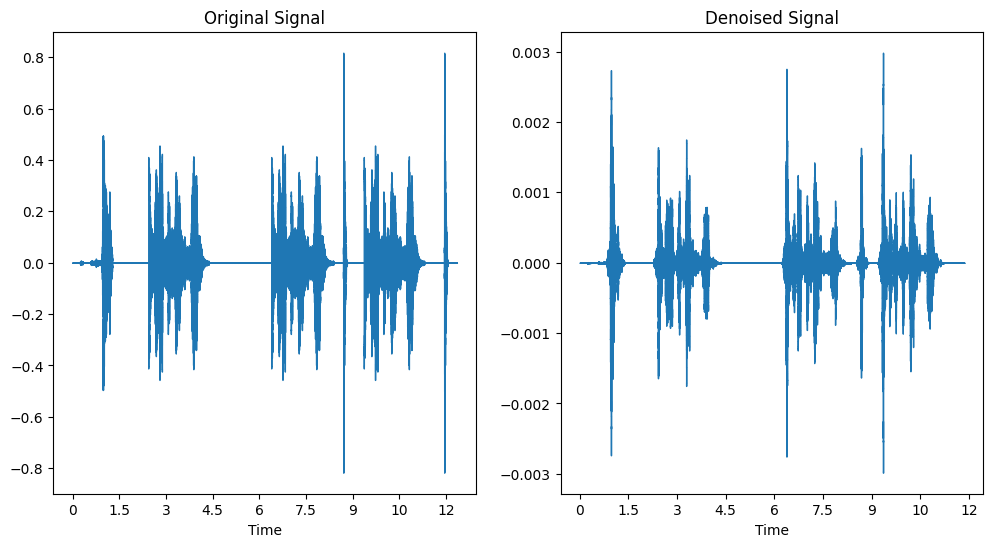

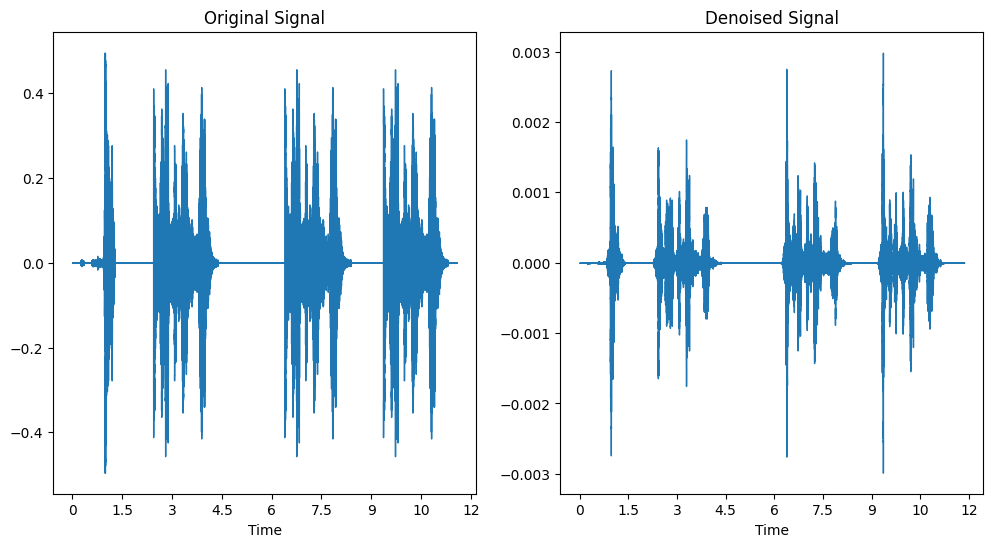

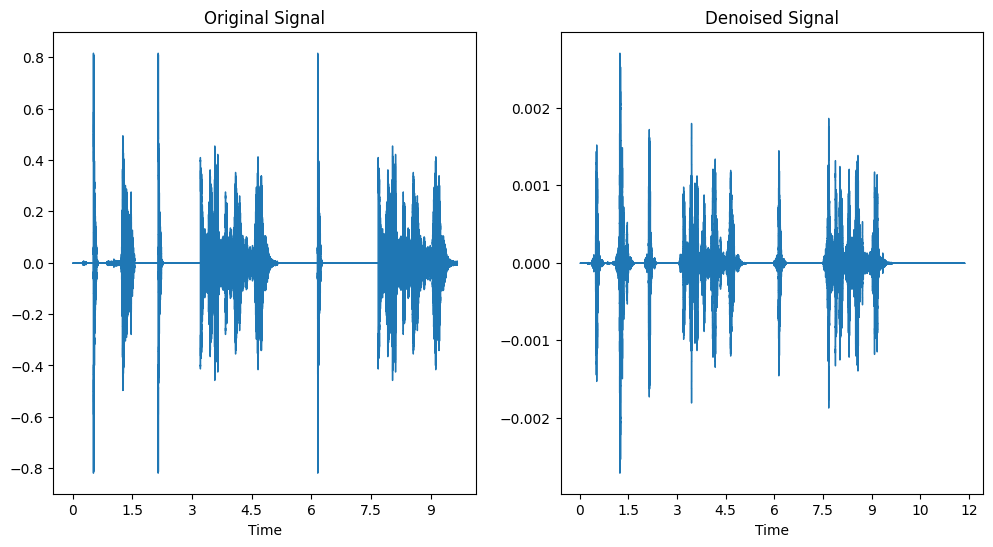

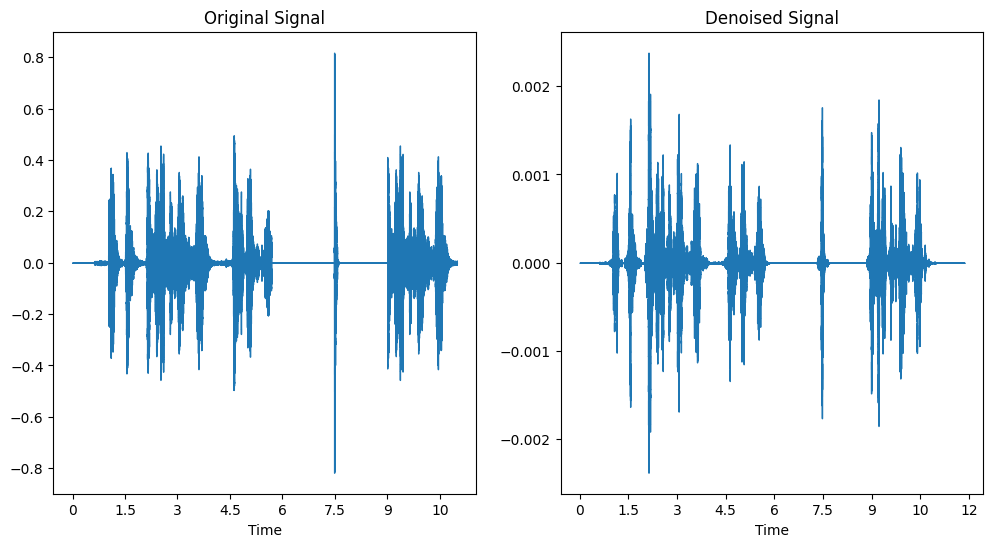

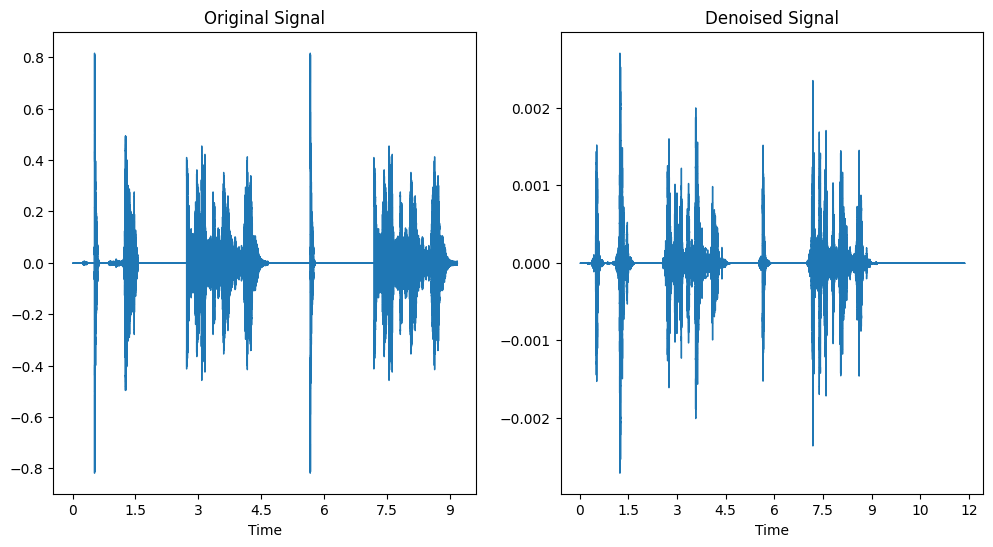

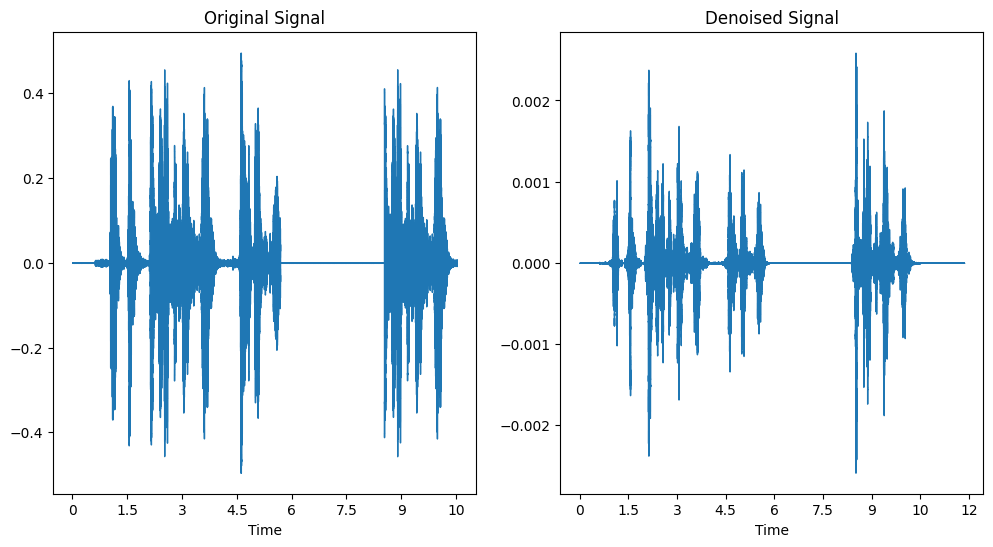

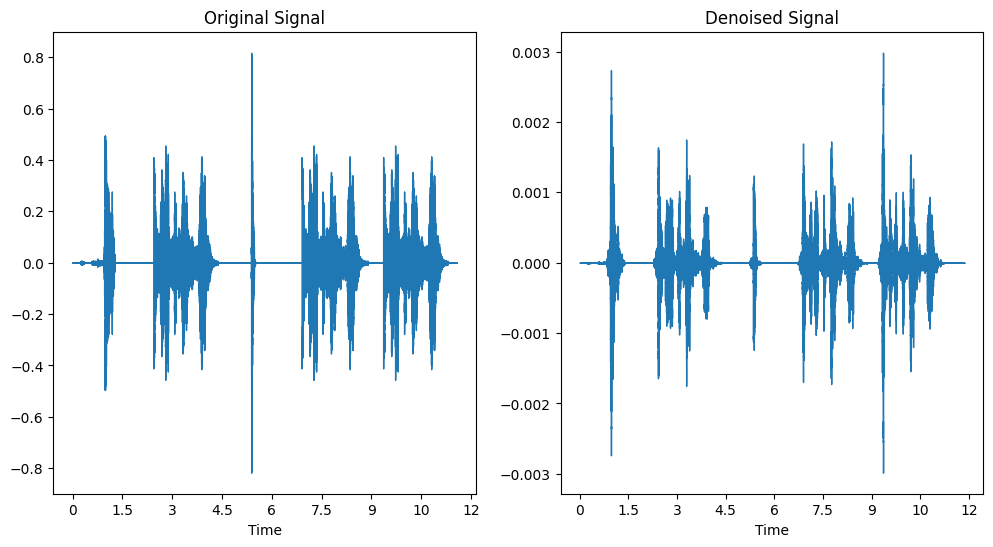

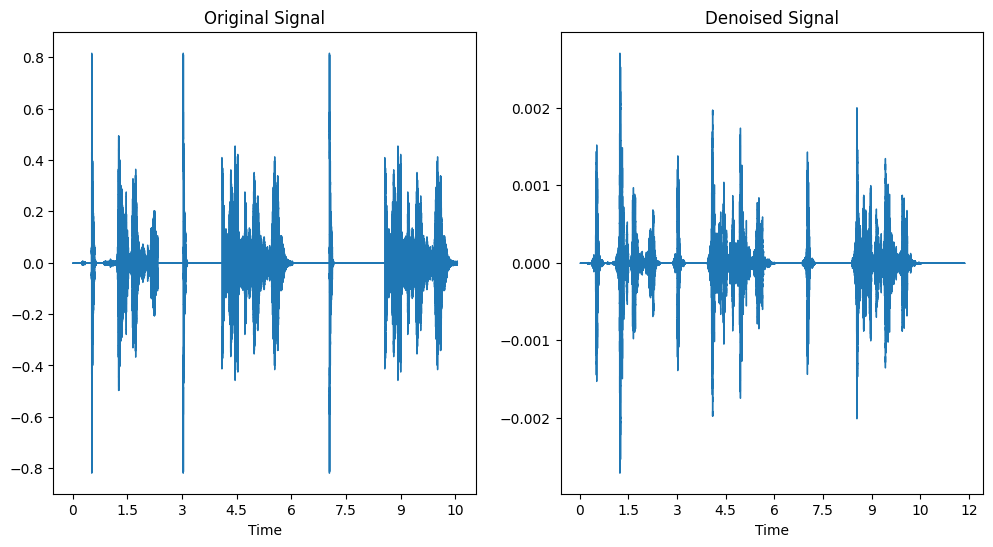

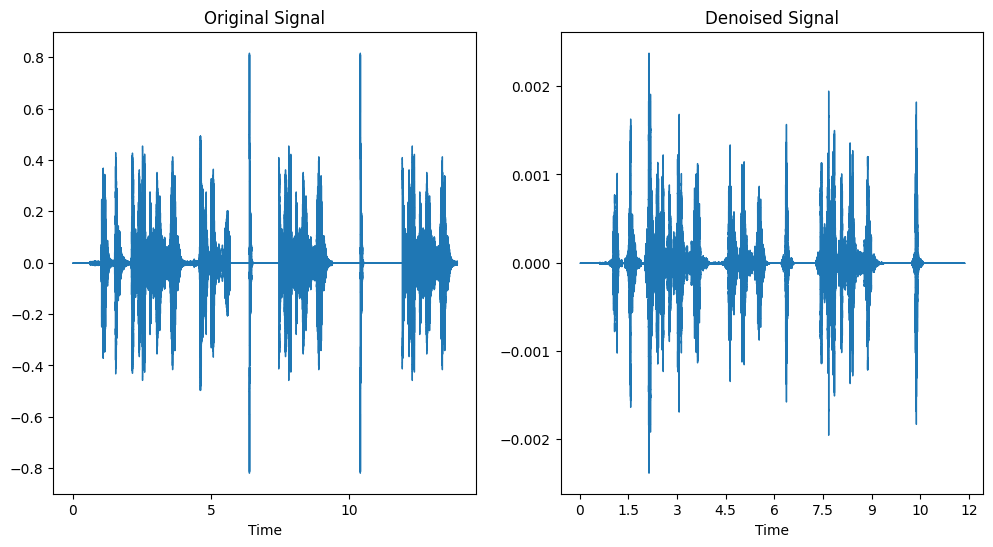

In [58]:
# Compare denoised results with original signals
import matplotlib.pyplot as plt
for i, (original, denoised) in enumerate(zip(noisy_signals, denoised_signals)):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(original, sr=44100)
    plt.title('Original Signal')
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(denoised, sr=44100)
    plt.title('Denoised Signal')
    plt.show()  
    

In [59]:
# Save denoised recordings
import soundfile as sf

output_dir = "../output/denoised/"
os.makedirs(output_dir, exist_ok=True)
for i, signal in enumerate(denoised_signals):
    sf.write(os.path.join(output_dir, f"denoised_{i+1}.wav"), signal, sr, format='WAV')